### NLP Ticketing System

## import libraries

In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import json

%matplotlib inline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
import itertools
from pprint import pprint

import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import missingno as msno
import re

from nltk.corpus import stopwords

import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.naive_bayes import MultinomialNB

[nltk_data] Error loading stopwords: <urlopen error [WinError 10054]
[nltk_data]     An existing connection was forcibly closed by the
[nltk_data]     remote host>


# Loading the data

In [5]:
f = open('client_data.json')

In [6]:
data = json.load(f)
df = pd.json_normalize(data)


In [7]:
df.head(10)

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A
5,complaint-public-v2,complaint,3275312,0.0,Older American,48227,3275312,Managing an account,2019-06-13T12:00:00-05:00,MI,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Referral,2019-06-14T12:00:00-05:00,None,Checking account,Yes,,Problem using a debit or ATM card,N/A
6,complaint-public-v2,complaint,3238804,0.0,None,76262,3238804,Managing an account,2019-05-10T12:00:00-05:00,TX,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Phone,2019-05-10T12:00:00-05:00,None,Checking account,Yes,,Problem using a debit or ATM card,N/A
7,complaint-public-v2,complaint,3249272,0.0,None,07753,3249272,Trouble during payment process,2019-05-15T12:00:00-05:00,NJ,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-05-21T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,N/A
8,complaint-public-v2,complaint,3351653,0.0,None,60621,3351653,Closing an account,2019-08-22T12:00:00-05:00,IL,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-08-23T12:00:00-05:00,None,Checking account,Yes,,Company closed your account,N/A
9,complaint-public-v2,complaint,3273612,0.0,None,99354,3273612,Managing an account,2019-06-11T12:00:00-05:00,WA,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Referral,2019-06-17T12:00:00-05:00,None,Checking account,Yes,,Cashing a check,N/A


In [8]:
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [9]:
print(len(df))

78313


In [10]:
df.shape

(78313, 22)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [12]:
df.describe()

,_score
count,78313.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


In [68]:
df.dtypes

_index                                object
_type                                 object
_id                                   object
_score                               float64
_source.tags                          object
_source.zip_code                      object
_source.complaint_id                  object
_source.issue                         object
_source.date_received                 object
_source.state                         object
_source.consumer_disputed             object
_source.product                       object
_source.company_response              object
_source.company                       object
_source.submitted_via                 object
_source.date_sent_to_company          object
_source.company_public_response       object
_source.sub_product                   object
_source.timely                        object
_source.complaint_what_happened       object
_source.sub_issue                     object
_source.consumer_consent_provided     object
dtype: obj

In [13]:
#Assign new column names

df.columns = ['index', 'type', 'id', 'score', 'tags', 'zip_code','complaint_id', 'issue', 'date_received',
       'state', 'consumer_disputed', 'product','company_response', 'company', 'submitted_via',
       'date_sent_to_company', 'company_public_response','sub_product', 'timely',
       'complaint_what_happened', 'sub_issue','consumer_consent_provided']

<AxesSubplot:>

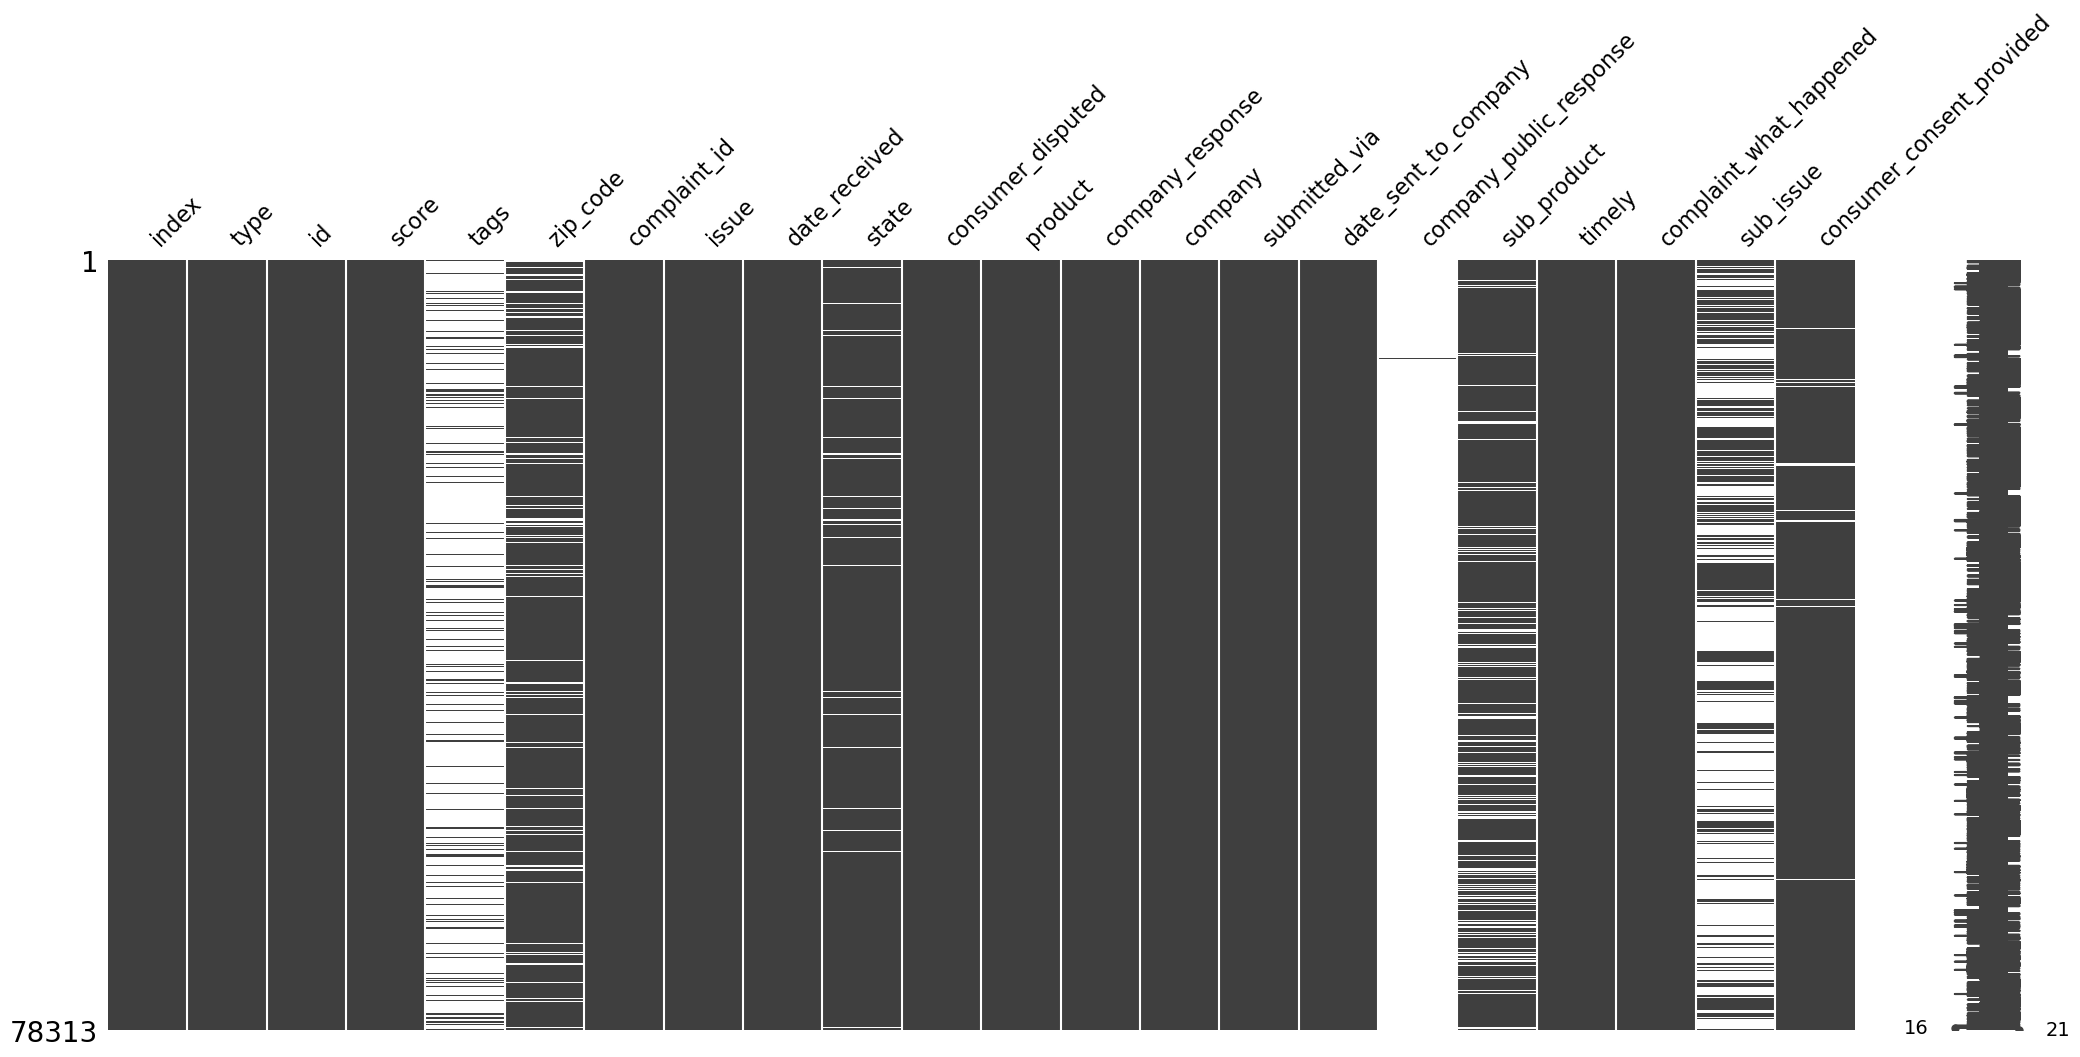

In [14]:

#Visualize the missing values across the columns in the dataframe
msno.matrix(df)

In [69]:
# creating new dataset using required columns
data = df[['_source.sub_product','_source.complaint_what_happened','_source.sub_issue']]
data.columns = ['sub_product','complaint_what_happened','sub_issue']
data.head(10)

,sub_product,complaint_what_happened,sub_issue
0,Credit card debt,,Debt is not yours
1,Credit card debt,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt
2,General-purpose credit card or charge card,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card
3,Conventional home mortgage,,None
4,General-purpose credit card or charge card,,Charged too much interest
5,Checking account,,Problem using a debit or ATM card
6,Checking account,,Problem using a debit or ATM card
7,Conventional home mortgage,,None
8,Checking account,,Company closed your account
9,Checking account,,Cashing a check


In [15]:

#Assign nan in place of blanks in the complaints column

df[df.loc[:, 'complaint_what_happened'] == ''] = np.nan

In [17]:
# Check if blank values still exist

df[df.loc[:, 'complaint_what_happened'] == '']

In [18]:
#Remove all rows where complaints column is nan

df = df[~df['complaint_what_happened'].isnull()]

<AxesSubplot:>

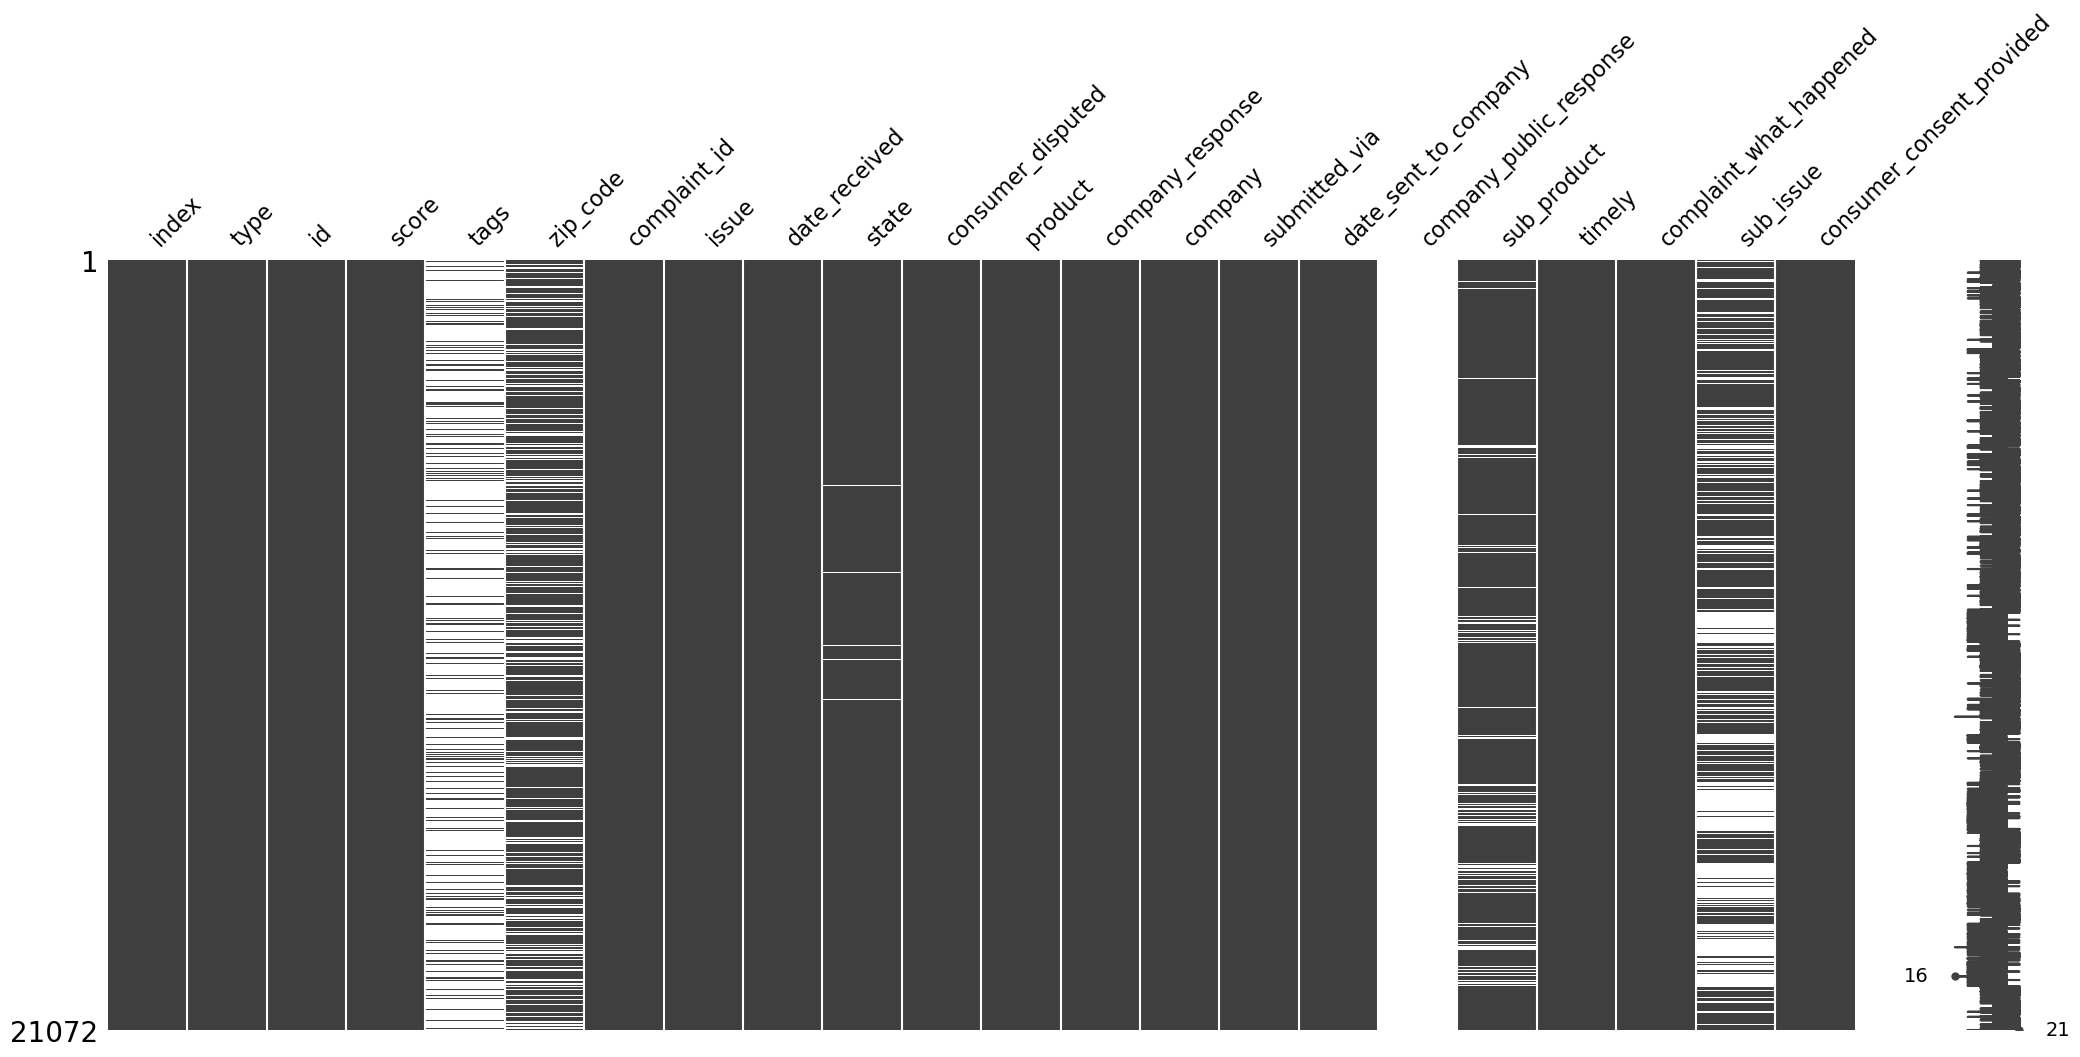

In [19]:
msno.matrix(df)

In [70]:
#length of rows containing blank rows
len(data[data['complaint_what_happened'] == ""])


57241

In [71]:
#Substituting the rows which contain null values in complaint_what_happened column to nan
data['complaint_what_happened'].replace("",np.nan,inplace=True)


In [72]:
data.shape

(78313, 3)

# Text Preprocessing


In [73]:
# removing stopwords 

stop_words = set(stopwords.words('English'))
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stop_words])
data['sub_product'] = data['sub_product'].apply(lambda text: cleaning_stopwords(text))
data['complaint_what_happened'] = data['complaint_what_happened'].apply(lambda text: cleaning_stopwords(text))
data['sub_issue'] = data['sub_issue'].apply(lambda text: cleaning_stopwords(text))
data.head()

,sub_product,complaint_what_happened,sub_issue
0,Credit card debt,nan,Debt
1,Credit card debt,Good morning name XXXX XXXX I appreciate could...,Didn't receive enough information verify debt
2,General-purpose credit card charge card,I upgraded XXXX XXXX card XX/XX/2018 told agen...,Problem rewards credit card
3,Conventional home mortgage,nan,None
4,General-purpose credit card charge card,nan,Charged much interest


In [74]:
# removing punctuations
regular_punct = list(string.punctuation)
def remove_punctuation(text,punct_list):
    for punc in punct_list:
        if punc in text:
            text = text.replace(punc, ' ')
    return text.strip()
data['complaint_what_happened'] = data['complaint_what_happened'].apply(lambda text: remove_punctuation(text,regular_punct))
data


,sub_product,complaint_what_happened,sub_issue
0,Credit card debt,nan,Debt
1,Credit card debt,Good morning name XXXX XXXX I appreciate could...,Didn't receive enough information verify debt
2,General-purpose credit card charge card,I upgraded XXXX XXXX card XX XX 2018 told agen...,Problem rewards credit card
3,Conventional home mortgage,nan,None
4,General-purpose credit card charge card,nan,Charged much interest
...,...,...,...
78308,Checking account,nan,Funds received closed account
78309,General-purpose credit card charge card,On Wednesday XX XX XXXX I called Chas XXXX X...,Other problem
78310,Checking account,I familiar XXXX pay understand great risk prov...,Transaction authorized
78311,General-purpose credit card charge card,I flawless credit 30 yrs I ve Chase credit ca...,Problem balance transfer


In [75]:
#removing numeric data
import re
def cleaning_numeric(text):
    return re.sub(r'[0-9]*','',text)
data['complaint_what_happened'] = data['complaint_what_happened'].apply(lambda text: cleaning_numeric(text))
data

,sub_product,complaint_what_happened,sub_issue
0,Credit card debt,nan,Debt
1,Credit card debt,Good morning name XXXX XXXX I appreciate could...,Didn't receive enough information verify debt
2,General-purpose credit card charge card,I upgraded XXXX XXXX card XX XX told agent up...,Problem rewards credit card
3,Conventional home mortgage,nan,None
4,General-purpose credit card charge card,nan,Charged much interest
...,...,...,...
78308,Checking account,nan,Funds received closed account
78309,General-purpose credit card charge card,On Wednesday XX XX XXXX I called Chas XXXX X...,Other problem
78310,Checking account,I familiar XXXX pay understand great risk prov...,Transaction authorized
78311,General-purpose credit card charge card,I flawless credit yrs I ve Chase credit card...,Problem balance transfer


In [76]:
#!pip install wordcloud

# EDA

(-0.5, 399.5, 199.5, -0.5)

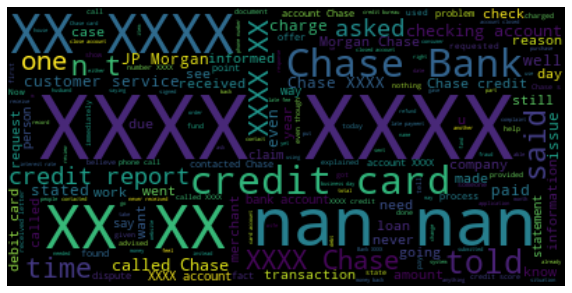

In [77]:
# creating word cloud
text = " ".join(review for review in data.complaint_what_happened.astype(str))
wordcloud = WordCloud().generate(text)
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

# Feature Extraction


In [78]:
vectorizer = TfidfVectorizer()
features = vectorizer.fit_transform(data.complaint_what_happened)

In [79]:
data

,sub_product,complaint_what_happened,sub_issue
0,Credit card debt,nan,Debt
1,Credit card debt,Good morning name XXXX XXXX I appreciate could...,Didn't receive enough information verify debt
2,General-purpose credit card charge card,I upgraded XXXX XXXX card XX XX told agent up...,Problem rewards credit card
3,Conventional home mortgage,nan,None
4,General-purpose credit card charge card,nan,Charged much interest
...,...,...,...
78308,Checking account,nan,Funds received closed account
78309,General-purpose credit card charge card,On Wednesday XX XX XXXX I called Chas XXXX X...,Other problem
78310,Checking account,I familiar XXXX pay understand great risk prov...,Transaction authorized
78311,General-purpose credit card charge card,I flawless credit yrs I ve Chase credit card...,Problem balance transfer


In [80]:
vocab = np.array(vectorizer.get_feature_names())
vocab.shape

(27981,)

In [81]:
from sklearn.decomposition import NMF
n_topics = 5
random_state = 42
nmf = NMF(n_components=n_topics, random_state=random_state)
nmf.fit(features)

NMF(n_components=5, random_state=42)

# Topic Modelling using NMF

In [82]:
# to display n top words from the document
n_top_words = 10
def display_top_words(n_top_words, vocab, nmf):
    for i, topic_vec in enumerate(nmf.components_):
        print(i, end=' ')
    for fid in topic_vec.argsort()[-1:-n_top_words-1:-1]:
        print(vocab[fid], end=' ')
    print()
        
display_top_words(10, vocab, nmf)

0 1 2 3 4 credit card chase report cards payment late balance interest never 


In [83]:
def topic_table(n_top_words, vocab, nmf):
    topics = {}
    for i, topic_vec in enumerate(nmf.components_):
        topic_descr = ''
        for fid in topic_vec.argsort()[-1:-n_top_words-1:-1]:
            topic_descr = topic_descr + vocab[fid] + " "
        topics[i] = topic_descr
    return pd.DataFrame({'Top_Topic_Terms': topics})

In [84]:
# Label topics with top 5 terms
topic_df = topic_table(5, vocab, nmf)
topic_df

,Top_Topic_Terms
0,nan variables resolution arithmetic report
1,xxxx chase loan mortgage the
2,account chase bank money check
3,xx on chase payment received
4,credit card chase report cards


In [85]:
# Manually label topics
topic_df['Label'] = ['Banking services', 'loans', 'Fraudalent reporting', 'Card', 'others']

In [86]:
document_weights = nmf.transform(vectorizer.transform(data['complaint_what_happened']))
document_weights

array([[6.46506947e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [0.00000000e+00, 5.34731519e-02, 3.06965019e-02, 0.00000000e+00,
        9.74226045e-03],
       [3.19341830e-12, 4.40533707e-02, 4.16482890e-03, 6.86883015e-02,
        3.40071079e-03],
       ...,
       [4.41525776e-10, 2.46125283e-02, 3.03282926e-02, 4.48048330e-04,
        1.49145941e-02],
       [0.00000000e+00, 1.54259877e-02, 2.40085840e-02, 3.79551192e-02,
        5.80403006e-02],
       [4.59568930e-10, 6.46703360e-03, 3.49916638e-02, 1.37543089e-03,
        3.90491486e-02]])

In [87]:
# Store most representative topic

data["Topic_idx"] = document_weights.argmax(axis=1)

In [88]:
# Joining the original dataset with labels
data = pd.merge(data, topic_df, left_on='Topic_idx', right_index=True, how='left')

In [89]:
data

,sub_product,complaint_what_happened,sub_issue,Topic_idx,Top_Topic_Terms,Label
0,Credit card debt,nan,Debt,0,nan variables resolution arithmetic report,Banking services
1,Credit card debt,Good morning name XXXX XXXX I appreciate could...,Didn't receive enough information verify debt,1,xxxx chase loan mortgage the,loans
2,General-purpose credit card charge card,I upgraded XXXX XXXX card XX XX told agent up...,Problem rewards credit card,3,xx on chase payment received,Card
3,Conventional home mortgage,nan,None,0,nan variables resolution arithmetic report,Banking services
4,General-purpose credit card charge card,nan,Charged much interest,0,nan variables resolution arithmetic report,Banking services
...,...,...,...,...,...,...
78308,Checking account,nan,Funds received closed account,0,nan variables resolution arithmetic report,Banking services
78309,General-purpose credit card charge card,On Wednesday XX XX XXXX I called Chas XXXX X...,Other problem,1,xxxx chase loan mortgage the,loans
78310,Checking account,I familiar XXXX pay understand great risk prov...,Transaction authorized,2,account chase bank money check,Fraudalent reporting
78311,General-purpose credit card charge card,I flawless credit yrs I ve Chase credit card...,Problem balance transfer,4,credit card chase report cards,others


# Model Training using Naive Bayes Algorithm

In [97]:
X = data.complaint_what_happened
y = data.Label


In [91]:
X

0                                                      nan
1        Good morning name XXXX XXXX I appreciate could...
2        I upgraded XXXX XXXX card XX XX  told agent up...
3                                                      nan
4                                                      nan
                               ...                        
78308                                                  nan
78309    On Wednesday  XX XX XXXX I called Chas  XXXX X...
78310    I familiar XXXX pay understand great risk prov...
78311    I flawless credit  yrs  I ve Chase credit card...
78312    Roughly   years ago I closed accounts JP Morga...
Name: complaint_what_happened, Length: 78313, dtype: object

In [92]:
y

0            Banking services
1                       loans
2                        Card
3            Banking services
4            Banking services
                 ...         
78308        Banking services
78309                   loans
78310    Fraudalent reporting
78311                  others
78312                  others
Name: Label, Length: 78313, dtype: object

In [93]:
#splitting dataset into train and test dataset

x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.05,random_state=26105111)

In [94]:
#Using TF-IDF 

from sklearn.feature_extraction.text import TfidfVectorizer
vec = TfidfVectorizer()
vec.fit(x_train)

TfidfVectorizer()

In [95]:
x_train = vec.transform(x_train)
x_test = vec.transform(x_test)

In [96]:
#implementing models using MultinomialNB classification
multi_nb = MultinomialNB()
multi_nb.fit(x_train,y_train)
y_pred = multi_nb.predict(x_test)
print(classification_report(y_test,y_pred))

                      precision    recall  f1-score   support

    Banking services       1.00      1.00      1.00      2847
                Card       0.00      0.00      0.00       156
Fraudalent reporting       0.69      0.70      0.70       304
               loans       0.54      0.89      0.68       357
              others       0.83      0.58      0.68       252

            accuracy                           0.90      3916
           macro avg       0.61      0.63      0.61      3916
        weighted avg       0.88      0.90      0.89      3916

